# Result Analysis
We use the pickled predictions to run our own analysis and create visualizations.

In [16]:
import pickle
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mmaction.evaluation.metrics.acc_metric import ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams.update(
    {
        "font.family": "serif",  # use serif/main font for text elements
        "text.usetex": True,  # use inline math for ticks
        "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    }
)

In [17]:
PREDICTIONS_FILE = "notebooks/predictions.pkl"

with open(PREDICTIONS_FILE, "rb") as f:
    predictions = pickle.load(f)

predictions[:3]

gt_labels = [p["gt_label"] for p in predictions]
pred_labels = [p["pred_label"] for p in predictions]
pred_scores = [p["pred_score"] for p in predictions]
pred_labels[:3], pred_scores[:3]

([tensor([2]), tensor([2]), tensor([2])],
 [tensor([0.0289, 0.0320, 0.9390]),
  tensor([0.0346, 0.0424, 0.9230]),
  tensor([0.0303, 0.0563, 0.9135])])

## Confusion Matrix

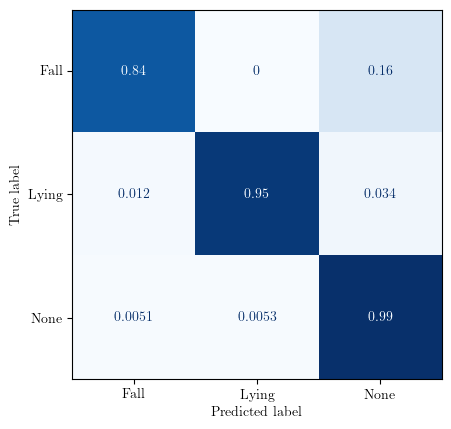

In [18]:
# Create the confusion matrix display
cf = ConfusionMatrixDisplay.from_predictions(
    gt_labels,
    pred_labels,
    normalize="true",
    display_labels=["Fall", "Lying", "None"],
    labels=[0, 1, 2],
    colorbar=False,
    cmap="Blues",
)

# Save the confusion matrix as a LaTeX Tikzplot
cf.figure_.savefig(
    "diagrams/confusion_matrix.pgf", format="pgf", bbox_inches="tight", pad_inches=0
)

# Metrics

In [19]:
from sklearn.metrics import classification_report

print(
    classification_report(
        gt_labels,
        pred_labels,
        target_names=["Fall", "Lying", "Other"],
        output_dict=False,
    )
)

              precision    recall  f1-score   support

        Fall       0.64      0.84      0.73        74
       Lying       0.98      0.95      0.96       983
       Other       0.99      0.99      0.99      4544

    accuracy                           0.98      5601
   macro avg       0.87      0.93      0.89      5601
weighted avg       0.98      0.98      0.98      5601



# Accessing Tensorboard files

In [20]:
from tbparse import SummaryReader
import pickle

experiment_path = Path("experiments/tensorboard/")
dump_path = Path("notebooks/tb_event_reader.pkl")

try:
    reader = pickle.load(open(dump_path, "rb"))
except FileNotFoundError:
    reader = SummaryReader(
        experiment_path, event_types={"scalars"}, extra_columns={"dir_name"}
    )
    pickle.dump(reader, open(dump_path, "wb"))

tb_data = reader.scalars
tb_data = tb_data.rename(
    columns={"tag": "metric", "dir_name": "experiment"},
)


def process_metric_name(metric_name):
    metric_name = metric_name.replace("acc/", "")
    metric_name = metric_name.replace("class_0_", "Fall_")
    metric_name = metric_name.replace("class_1_", "Lying_")
    metric_name = metric_name.replace("class_2_", "Other_")
    return metric_name


tb_data["metric"] = tb_data["metric"].apply(process_metric_name)

METRICS = [
    "Fall_f1",
    "Fall_precision",
    "Fall_recall",
    "Lying_f1",
    "Lying_precision",
    "Lying_recall",
    "Other_f1",
    "Other_precision",
    "Other_recall",
    "unweighted_average_f1",
    "loss",
]

tb_data = tb_data[tb_data["metric"].isin(METRICS)]

EXPERIMENTS = [
    "vit-uniform-sampling_priority-labeling_k400-hyperparams",
    "vit-uniform-sampling_priority-labeling_k400-hyperparams_weighted-ce-loss",
    "vit-b_gaussian-sampling_priority-labeling_k400-hyperparams",
    "vit-b_gaussian-sampling-5s-clips-30-drop_priority-labeling_k400-hyperparams",
    "vit-b_frame-int-8_gaussian-sampling-5s-clips-30-drop_priority-labeling_k400-hyperparams",
]

tb_data = tb_data[tb_data["experiment"].isin(EXPERIMENTS)]
tb_data["experiment_id"] = tb_data["experiment"].apply(
    lambda x: EXPERIMENTS.index(x) + 1
)

tb_data = tb_data.sort_values(by=["experiment_id", "metric", "step"])
tb_data = tb_data.reset_index(drop=True)

tb_data.head()

,step,metric,value,experiment,experiment_id
0,1,Fall_f1,0.0000,vit-uniform-sampling_priority-labeling_k400-hy...,1
1,2,Fall_f1,0.0000,vit-uniform-sampling_priority-labeling_k400-hy...,1
2,3,Fall_f1,0.0000,vit-uniform-sampling_priority-labeling_k400-hy...,1
3,4,Fall_f1,0.0000,vit-uniform-sampling_priority-labeling_k400-hy...,1
4,5,Fall_f1,0.0625,vit-uniform-sampling_priority-labeling_k400-hy...,1


# Loss curves

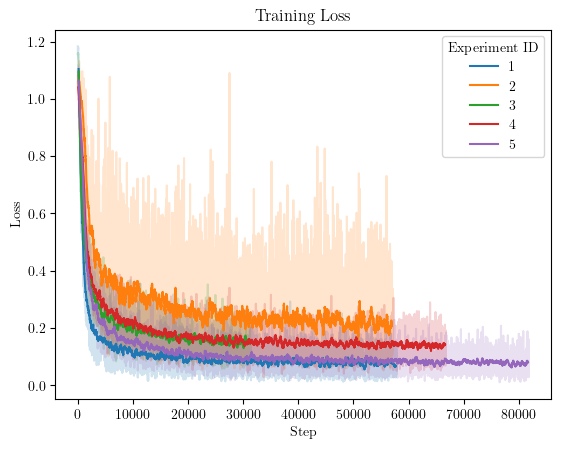

In [21]:
losses = tb_data[tb_data["metric"] == "loss"].copy()

losses["smoothed"] = (
    losses.groupby("experiment_id")["value"]
    .rolling(30, center=True)
    .mean()
    .reset_index(level=0, drop=True)
)
sns.lineplot(
    data=losses,
    x="step",
    y="value",
    hue="experiment_id",
    alpha=0.2,
    legend=False,
    palette="tab10",
)
sns.lineplot(data=losses, x="step", y="smoothed", hue="experiment_id", palette="tab10")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(title="Experiment ID")
plt.savefig("diagrams/loss_curves.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

# F1 Curves

In [22]:
f1_scores = tb_data[tb_data["metric"].str.contains("f1")].copy()

## Maximum F1 Scores table

In [23]:
unweighted_average_f1 = f1_scores[f1_scores["metric"] == "unweighted_average_f1"]
max_ids = unweighted_average_f1.groupby(["experiment_id"])["value"].idxmax()
max_f1_steps_index = (
    f1_scores.loc[max_ids][["experiment_id", "step"]]
    .set_index(["experiment_id", "step"])
    .index
)
f1_scores_index = f1_scores.set_index(["experiment_id", "step"]).index
max_f1_scores = f1_scores[f1_scores_index.isin(max_f1_steps_index)]

display(max_f1_scores)

,step,metric,value,experiment,experiment_id
60,61,Fall_f1,0.627451,vit-uniform-sampling_priority-labeling_k400-hy...,1
252,61,Lying_f1,0.903226,vit-uniform-sampling_priority-labeling_k400-hy...,1
444,61,Other_f1,0.978031,vit-uniform-sampling_priority-labeling_k400-hy...,1
6375,61,unweighted_average_f1,0.836236,vit-uniform-sampling_priority-labeling_k400-hy...,1
6409,31,Fall_f1,0.452381,vit-uniform-sampling_priority-labeling_k400-hy...,2
6598,31,Lying_f1,0.907923,vit-uniform-sampling_priority-labeling_k400-hy...,2
6787,31,Other_f1,0.967396,vit-uniform-sampling_priority-labeling_k400-hy...,2
12641,31,unweighted_average_f1,0.775900,vit-uniform-sampling_priority-labeling_k400-hy...,2
12676,9,Fall_f1,0.389610,vit-b_gaussian-sampling_priority-labeling_k400...,3
12760,9,Lying_f1,0.903371,vit-b_gaussian-sampling_priority-labeling_k400...,3


In [24]:
# Pivot the data

pivot_max_f1_scores = max_f1_scores[["metric", "value", "experiment_id"]].pivot(
    values="value", index="experiment_id", columns="metric"
)
print(pivot_max_f1_scores.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
metric & Fall_f1 & Lying_f1 & Other_f1 & unweighted_average_f1 \\
experiment_id &  &  &  &  \\
\midrule
1 & 0.63 & 0.90 & 0.98 & 0.84 \\
2 & 0.45 & 0.91 & 0.97 & 0.78 \\
3 & 0.39 & 0.90 & 0.98 & 0.76 \\
4 & 0.52 & 0.89 & 0.98 & 0.80 \\
5 & 0.74 & 0.92 & 0.98 & 0.88 \\
\bottomrule
\end{tabular}



In [25]:
f1_scores[["experiment_id", "step"]]

,experiment_id,step
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
32413,5,86
32414,5,87
32415,5,88
32416,5,89


# Label Distributions

In [26]:
from datasets import HighQualityFallDataset
from datasets.transforms.sampling_strategy import GaussianSampling, UniformSampling
from datasets.transforms.label_strategy import PriorityLabel, HQFD_LABEL_DESCRIPTION

train_ann_file = "data/Fall_Simulation_Data/annotations_train.csv"

hqfd_A = HighQualityFallDataset(
    ann_file=train_ann_file,
    sampling_strategy=UniformSampling(clip_len=10),
    label_strategy=PriorityLabel(HQFD_LABEL_DESCRIPTION),
    pipeline=[],
    num_classes=3,
    test_mode=False,
)

hqfd_B = HighQualityFallDataset(
    ann_file=train_ann_file,
    sampling_strategy=GaussianSampling(clip_len=10),
    label_strategy=PriorityLabel(HQFD_LABEL_DESCRIPTION),
    pipeline=[],
    num_classes=3,
    test_mode=False,
)

hqfd_C = HighQualityFallDataset(
    ann_file=train_ann_file,
    sampling_strategy=GaussianSampling(
        clip_len=5, fallback_sampler=UniformSampling(clip_len=5, stride=5)
    ),
    label_strategy=PriorityLabel(HQFD_LABEL_DESCRIPTION),
    pipeline=[],
    num_classes=3,
    test_mode=False,
)

datalist_A = pd.DataFrame(hqfd_A.load_data_list())
datalist_A["data_code"] = "A"
datalist_B = pd.DataFrame(hqfd_B.load_data_list())
datalist_B["data_code"] = "B"
datalist_C = pd.DataFrame(hqfd_C.load_data_list())
datalist_C["data_code"] = "C"
datalists = pd.concat([datalist_A, datalist_B, datalist_C])

class_names = ["Fall", "Lying", "Other"]
datalists["label_name"] = datalists["label"].apply(lambda x: class_names[x])


def extract_category(filename):
    match = re.search(r"(ADL|Fall)", filename.split("/")[-1])
    return match.group(1) if match else None


datalists["video_category"] = datalists["filename"].apply(extract_category)
datalists.head()

,filename,label,interval,data_code,label_name,video_category
0,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,2,"(0.0, 10.0)",A,Other,Fall
1,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,2,"(10.0, 20.0)",A,Other,Fall
2,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,0,"(20.0, 30.0)",A,Fall,Fall
3,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,0,"(30.0, 40.0)",A,Fall,Fall
4,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,1,"(40.0, 50.0)",A,Lying,Fall


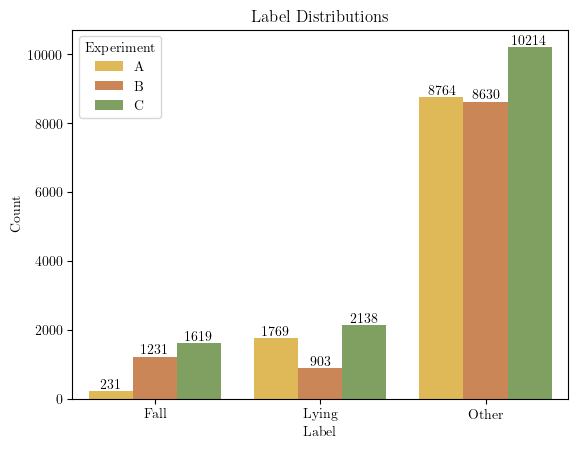

In [27]:
datalists = datalists.sort_values(by=["data_code", "label"])

# Calculate the counts in % of total for each bar
total_counts = (
    datalists.groupby(["label_name", "data_code"]).size().reset_index(name="count")
)
total_counts["percentage"] = (
    total_counts.groupby("data_code")["count"]
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(0, drop=True)
).round(2)


g = sns.barplot(
    data=total_counts,
    x="label_name",
    y="count",
    hue="data_code",
    legend=True,
    palette=["#F5C342", "#DE8344", "#7EAB55"],
)


for i, container in enumerate(g.containers):
    g.bar_label(container)


plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distributions")
g.get_legend().set_title("Experiment")
plt.savefig(
    "diagrams/label_distributions.pdf", format="pdf", bbox_inches="tight", pad_inches=0
)
plt.show()

In [28]:
# Make it a table

total_counts["value"] = total_counts.apply(
    lambda x: f"{x['count']:,} ({(x['percentage']/100):.1%})", axis=1
)

print(
    total_counts.pivot(
        index="label_name", columns="data_code", values="value"
    ).to_latex()
)

\begin{tabular}{llll}
\toprule
data_code & A & B & C \\
label_name &  &  &  \\
\midrule
Fall & 231 (2.1%) & 1,231 (11.4%) & 1,619 (11.6%) \\
Lying & 1,769 (16.4%) & 903 (8.4%) & 2,138 (15.3%) \\
Other & 8,764 (81.4%) & 8,630 (80.2%) & 10,214 (73.1%) \\
\bottomrule
\end{tabular}



# Merging results to video level

              precision    recall  f1-score   support

        Fall       0.95      0.96      0.95        55
         ADL       0.88      0.82      0.85        17

    accuracy                           0.93        72
   macro avg       0.91      0.89      0.90        72
weighted avg       0.93      0.93      0.93        72



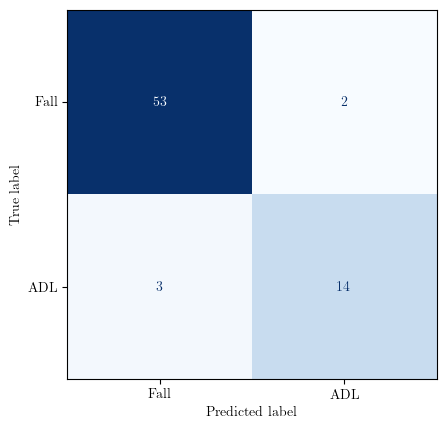

In [80]:
from datasets import HighQualityFallDataset
from datasets.transforms.sampling_strategy import GaussianSampling, UniformSampling
from datasets.transforms.label_strategy import PriorityLabel, HQFD_LABEL_DESCRIPTION

test_ann_file = "data/Fall_Simulation_Data/annotations_test.csv"

hqfd_test = HighQualityFallDataset(
    label_strategy=PriorityLabel(HQFD_LABEL_DESCRIPTION),
    ann_file=test_ann_file,
    num_classes=3,
    pipeline=[],
    test_mode=True,
    sampling_strategy=UniformSampling(clip_len=5, overlap=False, stride=0),
)

datalist_test = pd.DataFrame(hqfd_test.load_data_list())
datalist_test["prediction"] = pd.Series(pred_labels).astype(int)
datalist_test["prediction_score"] = pd.Series(
    [max(score) for score in pred_scores]
).astype(float)


def extract_category(filename):
    match = re.search(r"(ADL|Fall)", filename.split("/")[-1])
    return match.group(1) if match else None


datalist_test["video_category"] = datalist_test["filename"].apply(extract_category)

class_map = {
    "Fall": 0,
    "ADL": 2,
}

datalist_test["video_label"] = datalist_test["video_category"].replace(class_map)


video_level_predictions = pd.DataFrame(
    datalist_test.groupby("filename")["prediction"].min()
)
video_level_predictions["prediction"] = video_level_predictions["prediction"].replace(
    {1: 2}
)

video_level_predictions["video_label"] = datalist_test.groupby("filename")[
    "video_label"
].first()

print(
    classification_report(
        video_level_predictions["video_label"],
        video_level_predictions["prediction"],
        labels=[0, 2],
        target_names=["Fall", "ADL"],
        output_dict=False,
    )
)

cf = ConfusionMatrixDisplay.from_predictions(
    video_level_predictions["video_label"],
    video_level_predictions["prediction"],
    display_labels=["Fall", "ADL"],
    labels=[0, 2],
    colorbar=False,
    cmap="Blues",
)

# Video-level IOU calculation

In [102]:
# From https://github.com/activitynet/ActivityNet/blob/master/Evaluation/
def segment_iou(target_segment, candidate_segments):
    """Compute the temporal intersection over union between a
    target segment and all the test segments.

    Parameters
    ----------
    target_segment : 1d array
        Temporal target segment containing [starting, ending] times.
    candidate_segments : 2d array
        Temporal candidate segments containing N x [starting, ending] times.

    Outputs
    -------
    tiou : 1d array
        Temporal intersection over union score of the N's candidate segments.
    """
    tt1 = np.maximum(target_segment[0], candidate_segments[:, 0])
    tt2 = np.minimum(target_segment[1], candidate_segments[:, 1])
    # Intersection including Non-negative overlap score.
    segments_intersection = (tt2 - tt1).clip(0)
    # Segment union.
    segments_union = (
        (candidate_segments[:, 1] - candidate_segments[:, 0])
        + (target_segment[1] - target_segment[0])
        - segments_intersection
    )
    # Compute overlap as the ratio of the intersection
    # over union of two segments.
    tIoU = segments_intersection.astype(float) / segments_union
    return tIoU


def interpolated_prec_rec(prec, rec):
    """Interpolated AP - VOCdevkit from VOC 2011."""
    mprec = np.hstack([[0], prec, [0]])
    mrec = np.hstack([[0], rec, [1]])
    for i in range(len(mprec) - 1)[::-1]:
        mprec[i] = max(mprec[i], mprec[i + 1])
    idx = np.where(mrec[1::] != mrec[0:-1])[0] + 1
    ap = np.sum((mrec[idx] - mrec[idx - 1]) * mprec[idx])
    return ap


def compute_average_precision_detection(
    ground_truth, prediction, tiou_thresholds=np.linspace(0.5, 0.95, 10)
):
    """Compute average precision (detection task) between ground truth and
    predictions data frames. If multiple predictions occurs for the same
    predicted segment, only the one with highest score is matches as
    true positive. This code is greatly inspired by Pascal VOC devkit.

    Parameters
    ----------
    ground_truth : df
        Data frame containing the ground truth instances.
        Required fields: ['video-id', 't-start', 't-end']
    prediction : df
        Data frame containing the prediction instances.
        Required fields: ['video-id, 't-start', 't-end', 'score']
    tiou_thresholds : 1darray, optional
        Temporal intersection over union threshold.

    Outputs
    -------
    ap : float
        Average precision score.
    """
    ap = np.zeros(len(tiou_thresholds))
    if prediction.empty:
        return ap

    npos = float(len(ground_truth))
    lock_gt = np.ones((len(tiou_thresholds), len(ground_truth))) * -1
    # Sort predictions by decreasing score order.
    sort_idx = prediction["score"].values.argsort()[::-1]
    prediction = prediction.loc[sort_idx].reset_index(drop=True)

    # Initialize true positive and false positive vectors.
    tp = np.zeros((len(tiou_thresholds), len(prediction)))
    fp = np.zeros((len(tiou_thresholds), len(prediction)))

    # Adaptation to query faster
    ground_truth_gbvn = ground_truth.groupby("video-id")

    # Assigning true positive to truly grount truth instances.
    for idx, this_pred in prediction.iterrows():
        try:
            # Check if there is at least one ground truth in the video associated.
            ground_truth_videoid = ground_truth_gbvn.get_group(this_pred["video-id"])
        except Exception as e:
            fp[:, idx] = 1
            continue

        this_gt = ground_truth_videoid.reset_index()
        tiou_arr = segment_iou(
            this_pred[["t-start", "t-end"]].values, this_gt[["t-start", "t-end"]].values
        )
        # We would like to retrieve the predictions with highest tiou score.
        tiou_sorted_idx = tiou_arr.argsort()[::-1]
        for tidx, tiou_thr in enumerate(tiou_thresholds):
            for jdx in tiou_sorted_idx:
                if tiou_arr[jdx] < tiou_thr:
                    fp[tidx, idx] = 1
                    break
                if lock_gt[tidx, this_gt.loc[jdx]["index"]] >= 0:
                    continue
                # Assign as true positive after the filters above.
                tp[tidx, idx] = 1
                lock_gt[tidx, this_gt.loc[jdx]["index"]] = idx
                break

            if fp[tidx, idx] == 0 and tp[tidx, idx] == 0:
                fp[tidx, idx] = 1

    tp_cumsum = np.cumsum(tp, axis=1).astype(float)
    fp_cumsum = np.cumsum(fp, axis=1).astype(float)
    recall_cumsum = tp_cumsum / npos

    precision_cumsum = tp_cumsum / (tp_cumsum + fp_cumsum)

    for tidx in range(len(tiou_thresholds)):
        ap[tidx] = interpolated_prec_rec(
            precision_cumsum[tidx, :], recall_cumsum[tidx, :]
        )

    return ap

In [103]:
# Prepare ground truth for ANet evaluation

annotations = pd.read_csv("data/Fall_Simulation_Data/annotations_test.csv")
annotations["gt_fall_interval"] = annotations.apply(
    lambda x: (x["fall_start"], x["fall_end"]), axis=1
)

annotations = annotations[["video_path", "gt_fall_interval"]]
annotations = annotations.rename(columns={"video_path": "filename"})

annotations["video-id"] = annotations["filename"]
annotations["t-start"] = annotations["gt_fall_interval"].apply(lambda x: x[0])
annotations["t-end"] = annotations["gt_fall_interval"].apply(lambda x: x[1])

annotations = annotations.dropna()

annotations = annotations[["video-id", "t-start", "t-end"]].reset_index(drop=True)

annotations

,video-id,t-start,t-end
0,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,128.0,131.0
1,data/Fall_Simulation_Data/videos/Fall13_Cam3.mp4,24.0,27.0
2,data/Fall_Simulation_Data/videos/Fall1_Cam1.mp4,47.0,50.0
3,data/Fall_Simulation_Data/videos/Fall45_Cam2.mp4,20.0,22.0
4,data/Fall_Simulation_Data/videos/Fall22_Cam5.mp4,19.0,22.0
5,data/Fall_Simulation_Data/videos/Fall29_Cam4.mp4,23.0,25.0
6,data/Fall_Simulation_Data/videos/Fall27_Cam4.mp4,67.0,70.0
7,data/Fall_Simulation_Data/videos/Fall28_Cam2.mp4,68.0,70.0
8,data/Fall_Simulation_Data/videos/Fall10_Cam5.mp4,23.0,25.0
9,data/Fall_Simulation_Data/videos/Fall31_Cam1.mp4,65.0,67.0


In [104]:
# Prepare predictions for ANet evaluation


def concat_intervals(group):
    concatenated_rows = []
    score = 0
    count = 1
    for i, (_, row) in enumerate(group.iterrows()):
        # First row
        if not concatenated_rows:
            concatenated_rows.append(row)
            score = row["prediction_score"]
            continue

        # New block
        if row["prediction"] != concatenated_rows[-1]["prediction"]:
            concatenated_rows.append(row)
            concatenated_rows[-1]["prediction_score"] = score / count
            score = row["prediction_score"]
            count = 1
        # Same block
        else:
            concatenated_rows[-1]["interval"] = (
                concatenated_rows[-1]["interval"][0],
                row["interval"][1],
            )
            count += 1
            score += row["prediction_score"]
            # Last row and same block
            if i == len(group) - 1:
                concatenated_rows[-1]["prediction_score"] = score / count

    return pd.DataFrame(concatenated_rows)


predicted_intervals = (
    datalist_test.groupby("filename").apply(concat_intervals).reset_index(drop=True)
)

fall_intervals = predicted_intervals[predicted_intervals["prediction"] == 0]

fall_intervals = fall_intervals.rename(columns={"interval": "predicted_fall_interval"})

fall_intervals["video-id"] = fall_intervals["filename"]
fall_intervals["t-start"] = fall_intervals["predicted_fall_interval"].apply(
    lambda x: x[0]
)
fall_intervals["t-end"] = fall_intervals["predicted_fall_interval"].apply(
    lambda x: x[1]
)
fall_intervals["score"] = fall_intervals["prediction_score"]

fall_intervals = fall_intervals[["video-id", "t-start", "t-end", "score"]].reset_index(
    drop=True
)
fall_intervals

,video-id,t-start,t-end,score
0,data/Fall_Simulation_Data/videos/ADL12_Cam3.mp4,1000.0,1005.0,0.973675
1,data/Fall_Simulation_Data/videos/ADL12_Cam3.mp4,1105.0,1110.0,0.812018
2,data/Fall_Simulation_Data/videos/ADL12_Cam4.mp4,270.0,275.0,0.989435
3,data/Fall_Simulation_Data/videos/ADL15_Cam5.mp4,690.0,695.0,0.973979
4,data/Fall_Simulation_Data/videos/Fall10_Cam5.mp4,25.0,30.0,0.729522
...,...,...,...,...
67,data/Fall_Simulation_Data/videos/Fall5_Cam3.mp4,30.0,35.0,0.952380
68,data/Fall_Simulation_Data/videos/Fall5_Cam3.mp4,215.0,220.0,0.953219
69,data/Fall_Simulation_Data/videos/Fall6_Cam4.mp4,45.0,50.0,0.850325
70,data/Fall_Simulation_Data/videos/Fall6_Cam5.mp4,40.0,50.0,0.693482


[0.71650474 0.71650474 0.43232323 0.154001   0.02188906 0.02188906
 0.         0.         0.         0.        ]


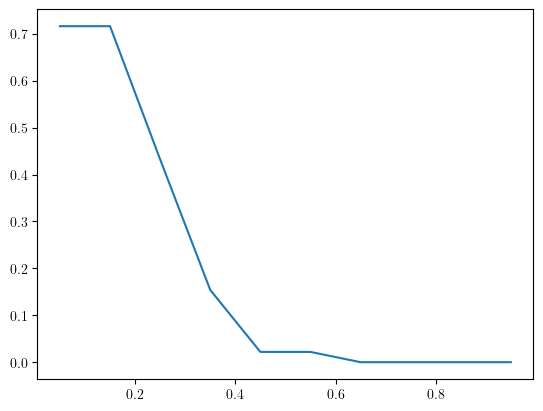

In [110]:
# Calculate AP with ANet evaluation

ap = compute_average_precision_detection(
    annotations, fall_intervals, tiou_thresholds=np.linspace(0.05, 0.95, 10)
)
print(ap)